In [35]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import bambi as bmb

# Ordinal Regression

- section on changing the default prior of cutpoints.

## Cumulative link model

In [65]:
trolly = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Trolley.csv", sep=";")
cols = ["response", "action", "intention", "contact"]
trolly = trolly[cols]
trolly["action"] = pd.Categorical(trolly["action"], ordered=False)
trolly["intention"] = pd.Categorical(trolly["intention"], ordered=False)
trolly["contact"] = pd.Categorical(trolly["contact"], ordered=False)
trolly["response"] = pd.Categorical(trolly["response"], ordered=True)

In [24]:
trolly.response.unique()

[4, 3, 5, 2, 1, 7, 6]
Categories (7, int64): [1 < 2 < 3 < 4 < 5 < 6 < 7]

### Intercept only model

In [ ]:
model = bmb.Model("response ~ 1", data=trolly, family="cumulative")
idata = model.fit()

In [23]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
response_threshold[0],-1.923,0.030,-1.978,-1.868,0.0,0.0,3964.0,2831.0,1.0
response_threshold[1],-1.269,0.024,-1.313,-1.226,0.0,0.0,4710.0,3680.0,1.0
response_threshold[2],-0.719,0.021,-0.759,-0.679,0.0,0.0,4719.0,2947.0,1.0
response_threshold[3],0.249,0.020,0.213,0.288,0.0,0.0,4610.0,3557.0,1.0
response_threshold[4],0.893,0.022,0.852,0.934,0.0,0.0,5110.0,3338.0,1.0
response_threshold[5],1.776,0.028,1.721,1.826,0.0,0.0,4841.0,3760.0,1.0


As the the cumalative link is used, we need to apply the logistic sigmoid function to transform back to cumulative probabilities.

In [50]:
expit_func = lambda x: 1 / (1 + np.exp(-x))
cumprobs = expit_func(idata.posterior.response_threshold).mean(("chain", "draw"))
cumprobs = np.append(cumprobs, 1)

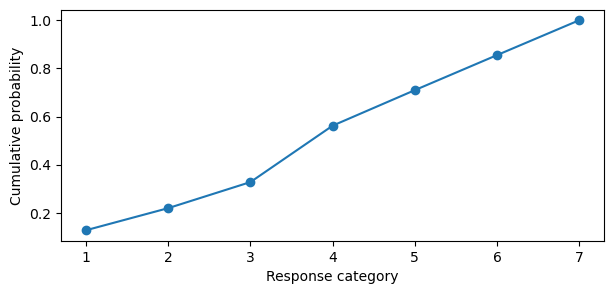

In [62]:
plt.figure(figsize=(7, 3))
plt.plot(sorted(trolly.response.unique()), cumprobs, marker='o')
plt.ylabel("Cumulative probability")
plt.xlabel("Response category");

The intercept only model above...

### Adding predictors


To include predictor variables, we define the log-cumulative-odds of each response $k$ as a sum of its intercept $\alpha_k$ and a linear model $\phi$ where $\phi_i = \beta x_i$

$$\text{log} \frac{Pr(y_i \le k)}{1 - Pr(y_i \le k)} = \alpha_k - \phi_i$$

The linear model $\phi$ is subtracted from each intercept because if we decrease the log-cumulative- odds of every outcome value $k$ below the maximum, this shifts probability mass upwards towards higher outcome values. Thus, positive $\beta$ values correspond to increasing $x$, which is associated with an increase in the mean $y$.

To add predictors for ordinal models in Bambi, we continue to use the familiar syntax.

In [68]:
model = bmb.Model(
    "response ~ action + intention + contact + action:intention + contact:intention", 
    data=trolly, 
    family="cumulative"
)
idata = model.fit()

/Users/gabestechschulte/Documents/repos/bambi/bambi/formula.py:111: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [response_threshold, action, intention, contact, action:intention, contact:intention]


/Users/gabestechschulte/miniforge3/envs/bambinos/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.


In [73]:
az.summary(
    idata, 
    var_names=["action", "intention", "contact", 
               "action:intention", "contact:intention"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
action[1],-0.465,0.055,-0.567,-0.363,0.001,0.001,2617.0,2808.0,1.0
intention[1],-0.274,0.058,-0.385,-0.168,0.001,0.001,2436.0,2892.0,1.0
contact[1],-0.323,0.069,-0.448,-0.192,0.001,0.001,2633.0,3029.0,1.0
"action:intention[1, 1]",-0.456,0.082,-0.604,-0.301,0.002,0.001,2666.0,2890.0,1.0
"contact:intention[1, 1]",-1.286,0.100,-1.479,-1.107,0.002,0.001,2676.0,3062.0,1.0


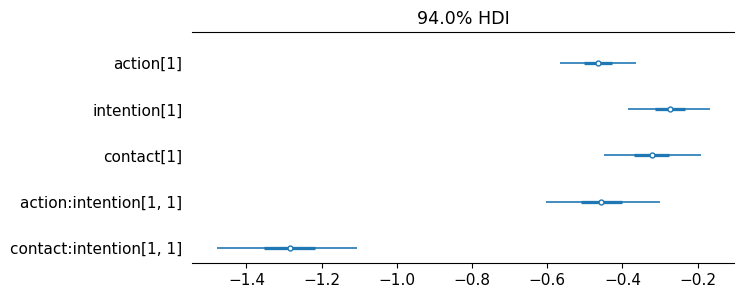

In [82]:
az.plot_forest(
    idata,
    combined=True,
    var_names=["action", "intention", "contact", 
               "action:intention", "contact:intention"],
    figsize=(7, 3),
    textsize=11
);